<a href="https://colab.research.google.com/github/dequiroz/MTR37C-TemasC/blob/main/MTR37C_VisuaOdometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Odometry

En esta sección se implementa un algoritmo de odometría visual monocular (una cámara) utilizando la secuencia de imágenes proporcionada.

. El script **`vo_utils.py`** contiene funciones que ayudan a simplificar el presente notebook, no modificar.

. La carpeta del dataset **`kitti_dataset/`** contiene los siguientes elementos:

- **`real_poses.txt`**: Contiene la trayectoria original del vehículo. Cada línea representa una matriz de transformación 3×4 (12 valores por línea), de la forma:

  
  \begin{bmatrix}
  r_{11} & r_{12} & r_{13} & t_x \\
  r_{21} & r_{22} & r_{23} & t_y \\
  r_{31} & r_{32} & r_{33} & t_z \\
  \end{bmatrix}
  


  Donde:
  - \( r_{ij} \): elementos de la matriz de rotación (orientación del vehículo).
  - \( t_x, t_y, t_z \): vector de traslación (posición del vehículo).

- **`calib.txt`**: Contiene los parámetros de calibración de las cámaras.

- **`images/`**: Contiene imágenes capturadas por la cámara.


## 1. Detección de feature points

Se implementa un método para detectar un número limitado de puntos clave por parche en una imagen.

*Un parche es una pequeña región de la imagen. Al detectar características por parche, se mejora la distribución espacial de los puntos clave, evitando que se concentren solo en zonas con mucha textura. Esto es clave en odometría visual y SLAM, donde una cobertura uniforme mejora la estimación del movimiento y la construcción del mapa.*

In [ ]:
!gdown 1pHyfFi2YMeeKXT2eoORT5KSK5c3dMSWP
!gdown 1Ga2g0l6naeBj0QvzstXnVEgCcYrvvcM5

Downloading...
From (original): https://drive.google.com/uc?id=1pHyfFi2YMeeKXT2eoORT5KSK5c3dMSWP
From (redirected): https://drive.google.com/uc?id=1pHyfFi2YMeeKXT2eoORT5KSK5c3dMSWP&confirm=t&uuid=0d237a89-ccbf-47ad-956d-57ab22fbad9f
To: /content/vo_utils.py
100% 7.92k/7.92k [00:00<00:00, 27.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Ga2g0l6naeBj0QvzstXnVEgCcYrvvcM5
From (redirected): https://drive.google.com/uc?id=1Ga2g0l6naeBj0QvzstXnVEgCcYrvvcM5&confirm=t&uuid=03be8e0f-4d74-4624-94da-b23734f23035
To: /content/kitti_dataset.zip
100% 278M/278M [00:04<00:00, 58.7MB/s]


In [ ]:
DATA_DIR = "kitti_dataset"
zip_file = DATA_DIR + '.zip'
!unzip -q {zip_file}

In [ ]:
from vo_utils import *
from tqdm import tqdm
class feature_detector:
    def __init__(self, threshold=20, nonmaxSuppression=True):
        self.detector = cv2.FastFeatureDetector_create(
            threshold=threshold, nonmaxSuppression=nonmaxSuppression
        )

    def detect(self, img):
        """
        Detecta puntos clave en toda la imagen usando el detector FAST.

        Parámetros:
            img (np.ndarray): Imagen en escala de grises.

        Retorna:
            np.ndarray: Arreglo de forma (N, 1, 2) con las coordenadas (x, y) de cada punto detectado.
                        Cada punto se accede como: kp.pt = (x, y), donde x es la columna e y es la fila de la imagen.
        """
        detected_keypoints = self.detector.detect(img)
        detected_pts = np.array([kp.pt for kp in detected_keypoints], dtype=np.float32).reshape(-1, 1, 2)
        return detected_pts

    def selective_detect(self, img, tile_h=20, tile_w=20, max_keypoints_per_patch=10):
        """
        Detecta puntos clave en la imagen dividiéndola en parches y limitando la cantidad por parche.

        Parámetros:
            img (np.ndarray): Imagen en escala de grises.
            tile_h (int): Alto de cada parche.
            tile_w (int): Ancho de cada parche.
            max_keypoints_per_patch (int): Máximo número de puntos clave por parche.

        Retorna:
            np.ndarray: Arreglo de forma (N, 1, 2) con las coordenadas (x, y) de los puntos seleccionados.
                        Se garantiza una mejor distribución espacial de los puntos clave.
        """
        H, W = img.shape  # Altura y anchura de la imagen
        detected_keypoints = []

        for y in range(0, H, tile_h):
            for x in range(0, W, tile_w):
                # Recordar: el acceso a imagen es (fila, columna) → (y, x)
                patch = img[y:y+tile_h, x:x+tile_w]

                # Paso 1: Detectar puntos clave en el parche
                keypoints = self.detector.detect(patch)

                # Paso 2: Ajustar coordenadas locales al marco global
                for kp in keypoints:
                    kp.pt = (kp.pt[0] + x, kp.pt[1] + y)

                # Paso 3: Conservar solo los mejores puntos (de mayor calidad) y agregarlos a la lista detected_keypoints.
                keypoints = sorted(keypoints, key=lambda kp: kp.response, reverse=True)

                for i in range(min(max_keypoints_per_patch, len(keypoints))):
                    detected_keypoints.append(keypoints[i])

        # Convertir los puntos detectados a un arreglo NumPy con forma (N, 1, 2)
        points = np.array([kp.pt for kp in detected_keypoints], dtype=np.float32).reshape(-1, 1, 2)
        return points

A continuación observará la comparación entre los dos métodos:

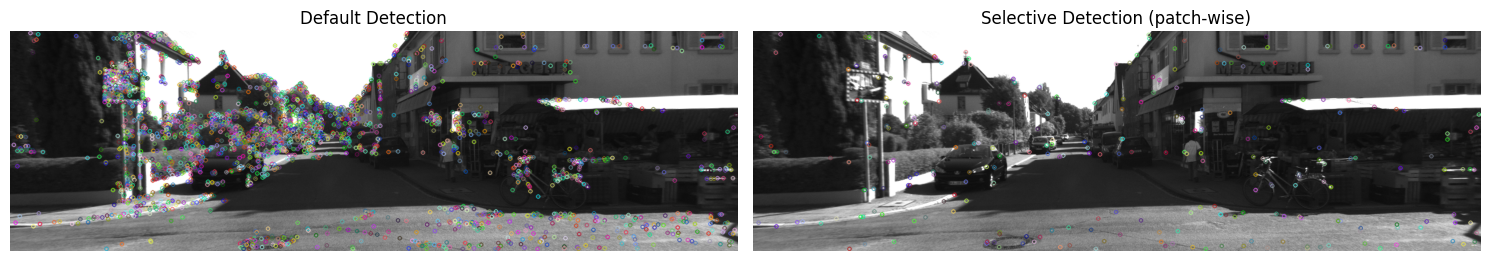

In [ ]:
# Detector
detector = feature_detector()
img = read_img(os.path.join(DATA_DIR, "images"), 0)

# Keypoints usando la detección FAST
feature_points = detector.detect(img)

# Keypoints usando la detección FAST selectiva
feature_points_selective = detector.selective_detect(img, tile_h=50, tile_w=50, max_keypoints_per_patch=2)

# Graficar
img_default = draw_keypoints(img.copy(), feature_points)
img_selective = draw_keypoints(img.copy(), feature_points_selective)

plot_detect_comparison(img_default, img_selective)

## 2. Seguimiento de feature points

Se implementa una parte del algoritmo de odometría visual utilizando el método **KLT (Kanade-Lucas-Tomasi)** para rastrear puntos entre dos imágenes consecutivas.


- Fórmulas de acumulación

**Traslación acumulada:**

$$
\mathbf{t}_{\text{accum}} = \mathbf{t}_{\text{accum}} + \text{scale} * \mathbf{R}_{\text{accum}} \cdot \mathbf{t}
$$

> Se transforma la traslación relativa t al marco de coordenadas global usando la rotación acumulada previa R_accum, y luego se suma a la trayectoria.


**Rotación acumulada:**

$$
\mathbf{R}_{\text{accum}} = \mathbf{R} \cdot \mathbf{R}_{\text{accum}}
$$

> Se actualiza la orientación global multiplicando la nueva rotación relativa por la rotación acumulada hasta el momento.

In [ ]:
class klt_feature_tracker:
    def __init__(self, camera_params, true_poses=None):
        """
        Inicializa el rastreador con parámetros del algoritmo de Lucas-Kanade.
        """
        self.lukas_kanade_params = LUKAS_KANADE_PARAMS
        self.focal_length = camera_params["focal_length"]
        self.principal_point = camera_params["principal_point"]
        self.R_accum = np.zeros((3, 3))  # Matriz de rotación acumulada
        self.t_accum = np.zeros((3, 1))  # Vector de traslación acumulado
        self.true_poses = true_poses

    def get_pose_from_tracks(self, feature_pts_img1, img1, img2):
        """
        Realiza el rastreo de puntos entre dos imágenes y estima la rotación (R) y traslación (t) relativas.

        Pasos:
            1. Usa el algoritmo de Lucas-Kanade para encontrar los puntos correspondientes en img2 y filtra los puntos inválidos o fuera de la imagen.
            2. Usa los puntos válidos para calcular la matriz esencial.
            3. Recupera R y t a partir de la matriz esencial.

        Parámetros:
            feature_pts_img1 (np.ndarray): Puntos clave detectados en img1.
            img1, img2 (np.ndarray): Imágenes en escala de grises consecutivas.

        Retorna:
            R (np.ndarray): Matriz de rotación estimada (3x3).
            t (np.ndarray): Vector de traslación estimado (3x1).
            tracked_pts_img1 (np.ndarray): Puntos rastreados válidos en img1.
            tracked_pts_img2 (np.ndarray): Puntos rastreados válidos en img2.
        """
        # Paso 1: Algoritmo ara encontrar correspondencias
        feature_pts_img2, status, _ = cv2.calcOpticalFlowPyrLK( img1, img2, prevPts=feature_pts_img1, nextPts=None, flags=cv2.MOTION_AFFINE, **self.lukas_kanade_params)

        tracked_pts_img1 = feature_pts_img1[status == 1]
        tracked_pts_img2 = feature_pts_img2[status == 1]

        # Paso 2: Eliminar puntos fuera de los límites de la imagen
        tracked_pts_img1, tracked_pts_img2 = check_inside_image(tracked_pts_img1, tracked_pts_img2, img1.shape)

        tracked_pts_img1 = tracked_pts_img1.astype("int32")
        tracked_pts_img2 = tracked_pts_img2.astype("int32")

        # Paso 3: Estimar R y t a partir de los puntos rastreados
        E, _ = cv2.findEssentialMat(tracked_pts_img1, tracked_pts_img2, focal=self.focal_length, pp=self.principal_point)
        _, R, t, _ = cv2.recoverPose(E=E, points1=tracked_pts_img1, points2=tracked_pts_img2, focal=self.focal_length, pp=self.principal_point)

        return R, t, tracked_pts_img1, tracked_pts_img2

    def track_step(self, img1, img2, feature_pts_img1, img_id, scale=1):
        """
        Estima el movimiento entre dos imágenes consecutivas y actualiza la trayectoria acumulada.

        Parámetros:
            img1, img2: Imágenes.
            feature_pts_img1: Puntos clave en img1.
            img_id: Índice de imagen actual.
            scale: Escala aplicada a la traslación.

        Retorna:
            t_accum: Traslación acumulada.
            tracked_pts_img2: Puntos rastreados en img2.
        """
        ## ======= COMPLETAR ESTA SECCIÓN =======
        R, t, tracked_pts_img1, tracked_pts_img2 = self.get_pose_from_tracks(feature_pts_img1, img1, img2)  # Encontrar puntos correspondientes y estimar R, t

        if img_id < 2:
            self.R_accum = R
            self.t_accum = t
        else:
            self.t_accum = self.t_accum + scale * self.R_accum @ t  # Acumular traslación
            self.R_accum = R @ self.R_accum  # Acumular rotación
        ## ================ FIN  ================

        return self.t_accum, tracked_pts_img2

A continuación se observa la comparación entre los dos métodos para dos imágenes consecutivas:

Sin selección selectiva:
  Tiempo: 0.0500 s | Puntos rastreados: 318
Con selección selectiva:
  Tiempo: 0.0072 s | Puntos rastreados: 105


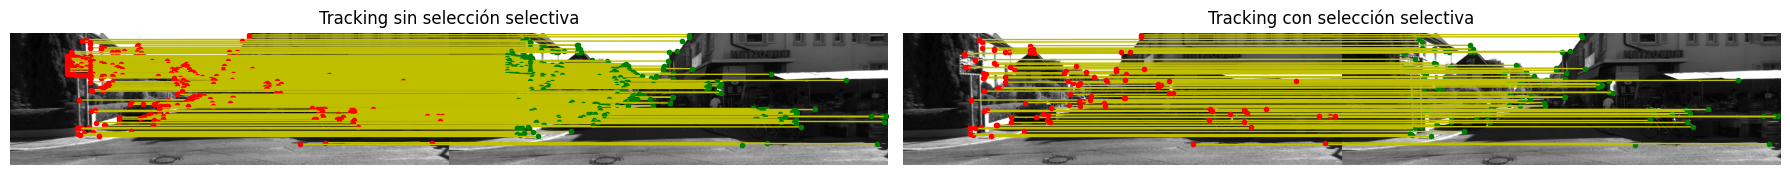

In [ ]:
# --- Cargar datos ---
_, img_file_path, calib_file_path = load_paths(DATA_DIR)
camera_params = load_calib(calib_file_path)
tracker = klt_feature_tracker(camera_params=camera_params)
detector = feature_detector(threshold=80)

img1 = cv2.imread(os.path.join(get_path_img(img_file_path, 0)), 0)
img2 = cv2.imread(os.path.join(get_path_img(img_file_path, 1)), 0)

# --- Tracking sin selección selectiva ---
start = time.time()
feature_points_std = detector.detect(img1)
_, _, tracked1_std, tracked2_std = tracker.get_pose_from_tracks(feature_points_std, img1, img2)
time_std = time.time() - start

# --- Tracking con selección selectiva ---
start = time.time()
feature_points_sel = detector.selective_detect(img1, tile_h=40, tile_w=40, max_keypoints_per_patch=2)
_, _, tracked1_sel, tracked2_sel = tracker.get_pose_from_tracks(feature_points_sel, img1, img2)
time_sel = time.time() - start

# --- Reporte ---
print("Sin selección selectiva:")
print(f"  Tiempo: {time_std:.4f} s | Puntos rastreados: {len(tracked1_std)}")

print("Con selección selectiva:")
print(f"  Tiempo: {time_sel:.4f} s | Puntos rastreados: {len(tracked1_sel)}")

# --- Visualización ---
plot_tracking_comparison(img1, img2, tracked1_std, tracked2_std, tracked1_sel, tracked2_sel)

## 3. Implementación de odometría monocular

In [ ]:
class visual_odometry_monocular:
    def __init__(self):
        # Cargar rutas de imágenes, calibración y poses
        self.pose_file_path, self.img_file_path, self.calib_file_path = load_paths(DATA_DIR)

        with open(self.pose_file_path) as f:
            self.true_poses = f.readlines()

        self.detector = feature_detector(threshold=20, nonmaxSuppression=True)
        self.feature_tracker = klt_feature_tracker(camera_params=load_calib(self.calib_file_path), true_poses=self.true_poses)

        # Leer el primer frame (imagen inicial)
        self.current_frame = cv2.imread(get_path_img(self.img_file_path, 0), 0)
        self.old_frame = self.current_frame

        # Inicializar variables de estado
        self.img_id = 0
        self.t = np.zeros((3, 1))

    def process_frame(self, img_id, scale=1):
        """
        Procesa un nuevo frame y estima el movimiento respecto al anterior.

        Pasos:
            1. Leer la nueva imagen.
            2. Detectar puntos clave en la imagen anterior.
            3. Usar KLT para rastrear los puntos y estimar el movimiento.
            4. Actualizar el estado interno (frame actual y t acumulado).

        Parámetros:
            img_id (int): ID del nuevo frame.
            scale (float): Escala aplicada a la traslación estimada.

        Retorna:
            tracked_points (np.ndarray): Puntos rastreados en el nuevo frame.
        """
        # Leer nueva imagen (grayscale)
        self.current_frame = read_img(self.img_file_path, img_id)

        ## ======= COMPLETAR ESTA SECCIÓN =======
        # Detectar puntos en el frame anterior, con máximo 2 puntos por parche de 50x50 píxeles
        feature_points = self.detector.selective_detect(
            self.old_frame, max_keypoints_per_patch=5, tile_h=50, tile_w=50
        )

        # Estimar movimiento con KLT y actualizar la traslación acumulada
        self.t, tracked_points = self.feature_tracker.track_step(
            self.old_frame, self.current_frame, feature_points, self.img_id, scale
        )
        ## ================ FIN  ================

        # Actualizar el frame anterior e ID
        self.img_id = img_id
        self.old_frame = self.current_frame


        return tracked_points

    def get_true_coordinates(self):
        """
        Retorna la posición verdadera del vehículo (ground truth) en el frame actual.
        """
        return get_vect_from_pose(self.true_poses[self.img_id - 1].strip().split()).squeeze()

    def get_mono_coordinates(self):
        """
        Retorna la posición estimada por odometría monocular, ajustando el eje z a convención OpenCV.
        """
        diag = np.array([[1, 0, 0],
                         [0, 1, 0],
                         [0, 0, -1]])  # Corrige orientación del eje z
        adj_coord = diag @ self.t
        return adj_coord.flatten()

In [ ]:
def odom_step(vo, plotter, i):
    """
    Ejecuta un paso de odometría visual para el frame i

    Parámetros:
        vo: Instancia de visual_odometry_monocular.
        plotter: Objeto que gestiona la visualización de la trayectoria.
        i (int): Índice del frame actual.

    Retorna:
        traj_est (np.ndarray): Imagen con trayectoria estimada.
        traj_real (np.ndarray): Imagen con trayectoria real.
    """
    tracked_points = vo.process_frame(i, scale=1)

    mono_coord = vo.get_mono_coordinates()
    true_coord = vo.get_true_coordinates()

    draw_x, _, draw_z = [int(x) for x in mono_coord]
    true_x, _, true_z = [int(x) for x in true_coord]

    traj_est, traj_real = plotter.get_trajectory_step(true_x, true_z, draw_x, draw_z)
    plotter.plot_step(show_features(vo.current_frame, tracked_points))

    return traj_est, traj_real


3.2. Generar trayectoria correcta.

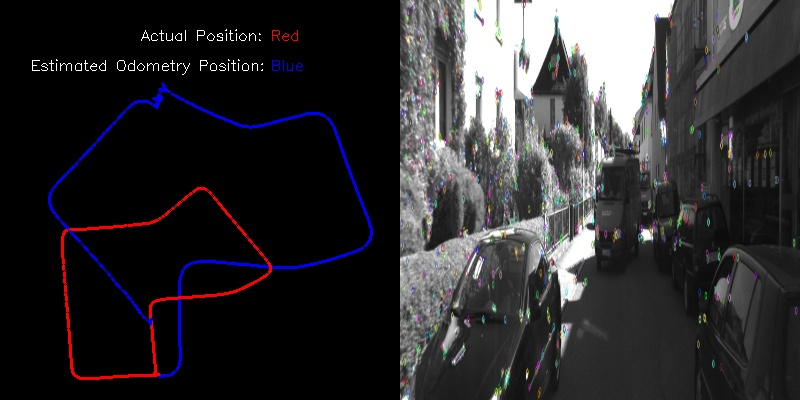

100%|██████████| 1101/1101 [00:58<00:00, 18.93it/s]


In [ ]:
plotter = Plotter()
vo = visual_odometry_monocular()
for i in tqdm(range(get_number_images(vo.img_file_path))):
    traj_est, traj_real_completa = odom_step(vo, plotter, i)

## 4. Mejora de odometría monocular

A continuación se valida que a partir de un punto X de la trayectoria el vehículo incrementa considerablemente su error de localización.

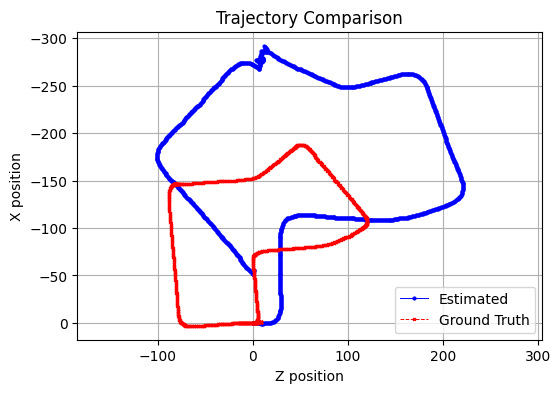

In [ ]:
plot_trajectories(
    trajectories=[traj_est, traj_real_completa],
    labels=['Estimated', 'Ground Truth'],
    colors=['blue', 'red']
)

## 4.1. Análisis de vehículo en estado estacionario

A continuación, se observa la sequencia de imágenes en la cuál el vehículo está quieto (punto X).

<div style="text-align: center;">
  <img src="https://drive.google.com/uc?export=view&id=1yw09nLygBuvKbJDEZBT0kCnndXneouFT" width="500">
</div>

In [ ]:
#Considere que el vehículo está en reposo desde la imagen 663 a las imagen 717
START_STATIC_IMG_NUM = 663
END_STATIC_IMG_NUM = 717

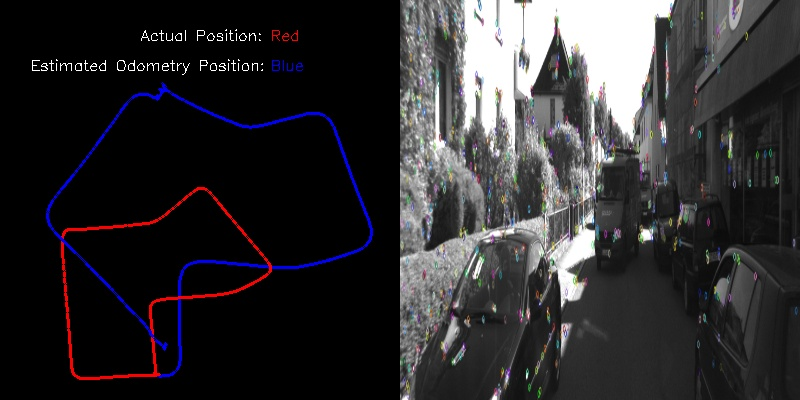

100%|██████████| 1101/1101 [00:39<00:00, 27.56it/s]


In [ ]:
def odom_remove_sequence(vo, plotter):
    for i in tqdm(range(get_number_images(vo.img_file_path))):
    ## ======= COMPLETAR ESTA SECCIÓN =======
        if i not in list(range(START_STATIC_IMG_NUM, END_STATIC_IMG_NUM)):
            traj_est, traj_real = odom_step(vo, plotter, i)
    ## ================ FIN  ================
    return traj_est, traj_real
plotter = Plotter()
vo = visual_odometry_monocular()
traj_est_solved, traj_real = odom_remove_sequence(vo, plotter)

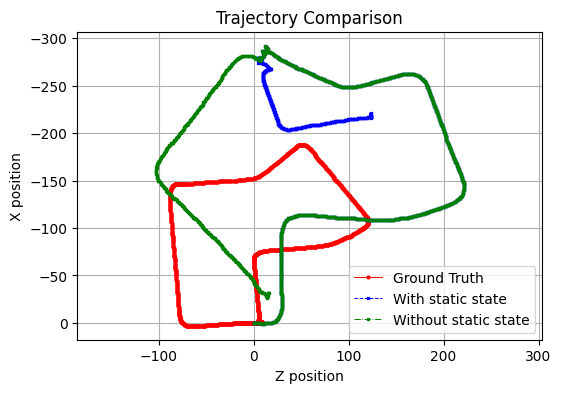

In [ ]:
plot_trajectories(
    trajectories=[traj_real, traj_est, traj_est_solved],
    labels=['Ground Truth', 'With static state', "Without static state"],
    colors=['red', 'blue', 'green']
)

## 4.2. Escala de odometría monocula

<div style="text-align: center;">
  <img src="https://drive.google.com/uc?export=view&id=1VgaBfv7NokLuWV7hJJGS1YggXDQ_EVZH" width="500">
</div>

In [ ]:
def odom_step(vo, plotter, i):
    prev_true_vect, act_true_vect = get_true_positions(vo, i) # Obtener las posiciones verdadera anterior y actual

    ## ======= COMPLETAR ESTA SECCIÓN =======
    scale = np.linalg.norm(act_true_vect - prev_true_vect)
    ## ================ FIN  ================

    tracked_points = vo.process_frame(i, scale=scale)

    mono_coord = vo.get_mono_coordinates()
    true_coord = vo.get_true_coordinates()

    draw_x, _, draw_z = [int(x) for x in mono_coord]
    true_x, _, true_z = [int(x) for x in true_coord]

    traj_est, traj_real = plotter.get_trajectory_step(true_x, true_z, draw_x, draw_z)
    plotter.plot_step(show_features(vo.current_frame, tracked_points))
    return traj_est, traj_real

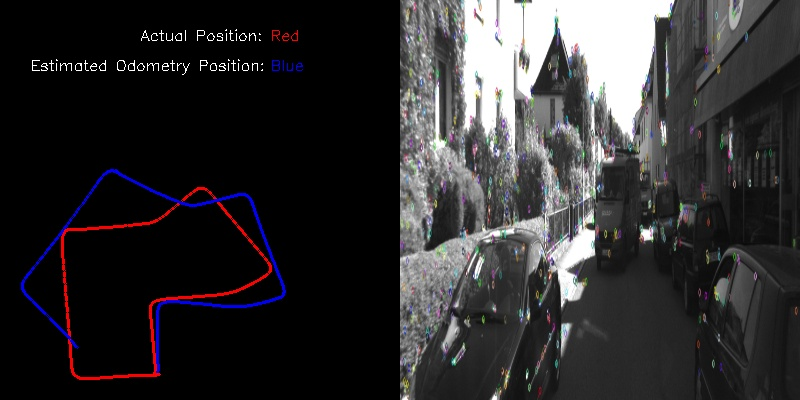

100%|██████████| 1101/1101 [00:37<00:00, 29.29it/s]


In [ ]:
plotter = Plotter()
vo = visual_odometry_monocular()

traj_est_scaled, traj_real = odom_remove_sequence(vo, plotter)

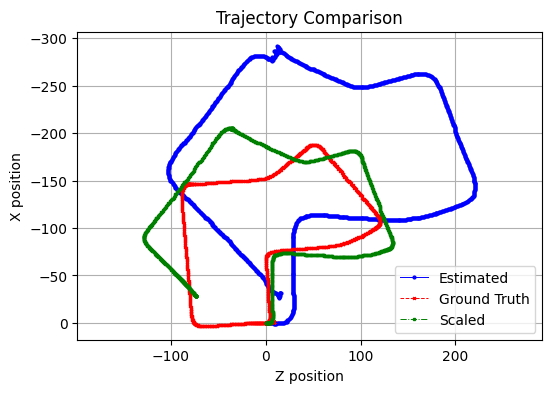

In [ ]:
plot_trajectories(
    trajectories=[traj_est_solved, traj_real, traj_est_scaled],
    labels=['Estimated', 'Ground Truth', "Scaled"],
    colors=['blue', 'red', 'green']
)

## 4.3. Loop Closure

Aplica una corrección lineal a la trayectoria estimada para cerrar el bucle.
Distribuye el error acumulado entre la primera y última posición a lo largo de toda la trayectoria.

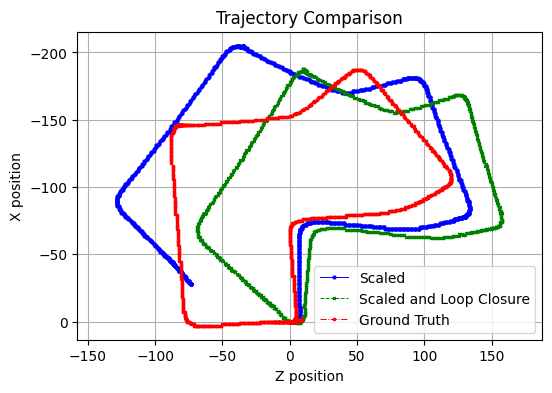

In [ ]:
def correct_loop_closure(traj):
    """
    Parámetros:
        traj (np.ndarray): Trayectoria estimada de forma (N, 2).

    Retorna:
        corrected_traj (np.ndarray): Trayectoria corregida con cierre de bucle.
    """

    error = traj[-1] - traj[0]

    correction = np.linspace(0, 1, traj.shape[0]).reshape(-1, 1) * error

    corrected_traj = traj - correction

    return corrected_traj

traj_corrected_closure = correct_loop_closure(traj_est_scaled)

# Visualizar resultado
plot_trajectories(
    [traj_est_scaled, traj_corrected_closure, traj_real],
    labels=["Scaled", "Scaled and Loop Closure", "Ground Truth"],
    colors=["blue", "green", "red"]
)

In [ ]:
from IPython.display import Markdown, display

table = f"""
| Trayectoria Estimada | MSE        |
|----------------------|------------|
| Inicial          | {compute_mse(traj_real_completa, traj_est):.2f} |
| Sin frenado          | {compute_mse(traj_real, traj_est_solved):.2f} |
| Escalada             | {compute_mse(traj_real, traj_est_scaled):.2f} |
| Loop Closure         | {compute_mse(traj_real, traj_corrected_closure):.2f} |
"""

display(Markdown(table))


| Trayectoria Estimada | MSE        |
|----------------------|------------|
| Inicial          | 23871.27 |
| Sin frenado          | 13621.62 |
| Escalada             | 3566.94 |
| Loop Closure         | 3654.00 |
